In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from ForecastSimulator import Forecastsimulator, forecast_split
from statsmodels.tsa.seasonal import seasonal_decompose
from datetime import date
from dateutil.relativedelta import relativedelta

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout, Bidirectional, TimeDistributed, GRU
from tensorflow.keras.layers import MaxPooling1D, Flatten
from tensorflow.keras.regularizers import L1, L2
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError, MeanAbsolutePercentageError
from scikeras.wrappers import KerasRegressor
from pandas_datareader import data as web

plt.rcParams['figure.figsize'] = (18, 10)
plt.rcParams['axes.labelsize'] = 15

In [2]:
today = date.today()
start_date = today - relativedelta(years=4)

print(start_date)
data = pd.DataFrame(web.DataReader('0RLS.UK', 'stooq', start_date))
data.info()

2018-11-12
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1028 entries, 2022-11-11 to 2018-11-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1028 non-null   float64
 1   High    1028 non-null   float64
 2   Low     1028 non-null   float64
 3   Close   1028 non-null   float64
 4   Volume  1016 non-null   float64
dtypes: float64(5)
memory usage: 48.2 KB


In [3]:
unicredit = data[['Close']]
unicredit = unicredit.sort_index(ascending = True)
unicredit

,Close
Date,
2018-11-12,10.4610
2018-11-13,10.6469
2018-11-14,10.5053
2018-11-15,10.3591
2018-11-16,10.2458
...,...
2022-11-07,12.8210
2022-11-08,12.8710
2022-11-09,12.8400


<AxesSubplot: xlabel='Date'>

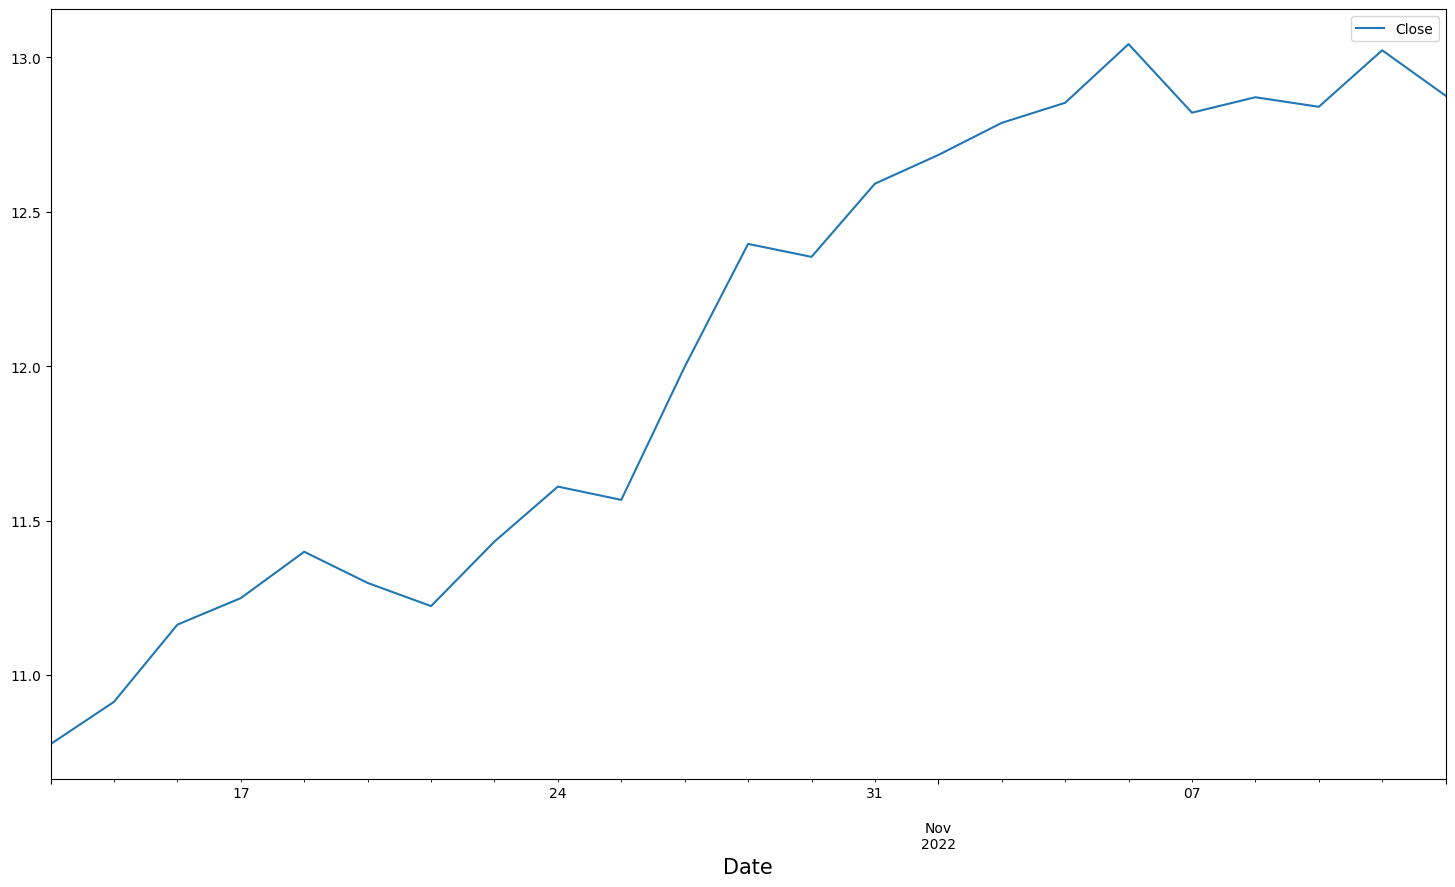

In [4]:
unicredit['2022-10-12':].plot()

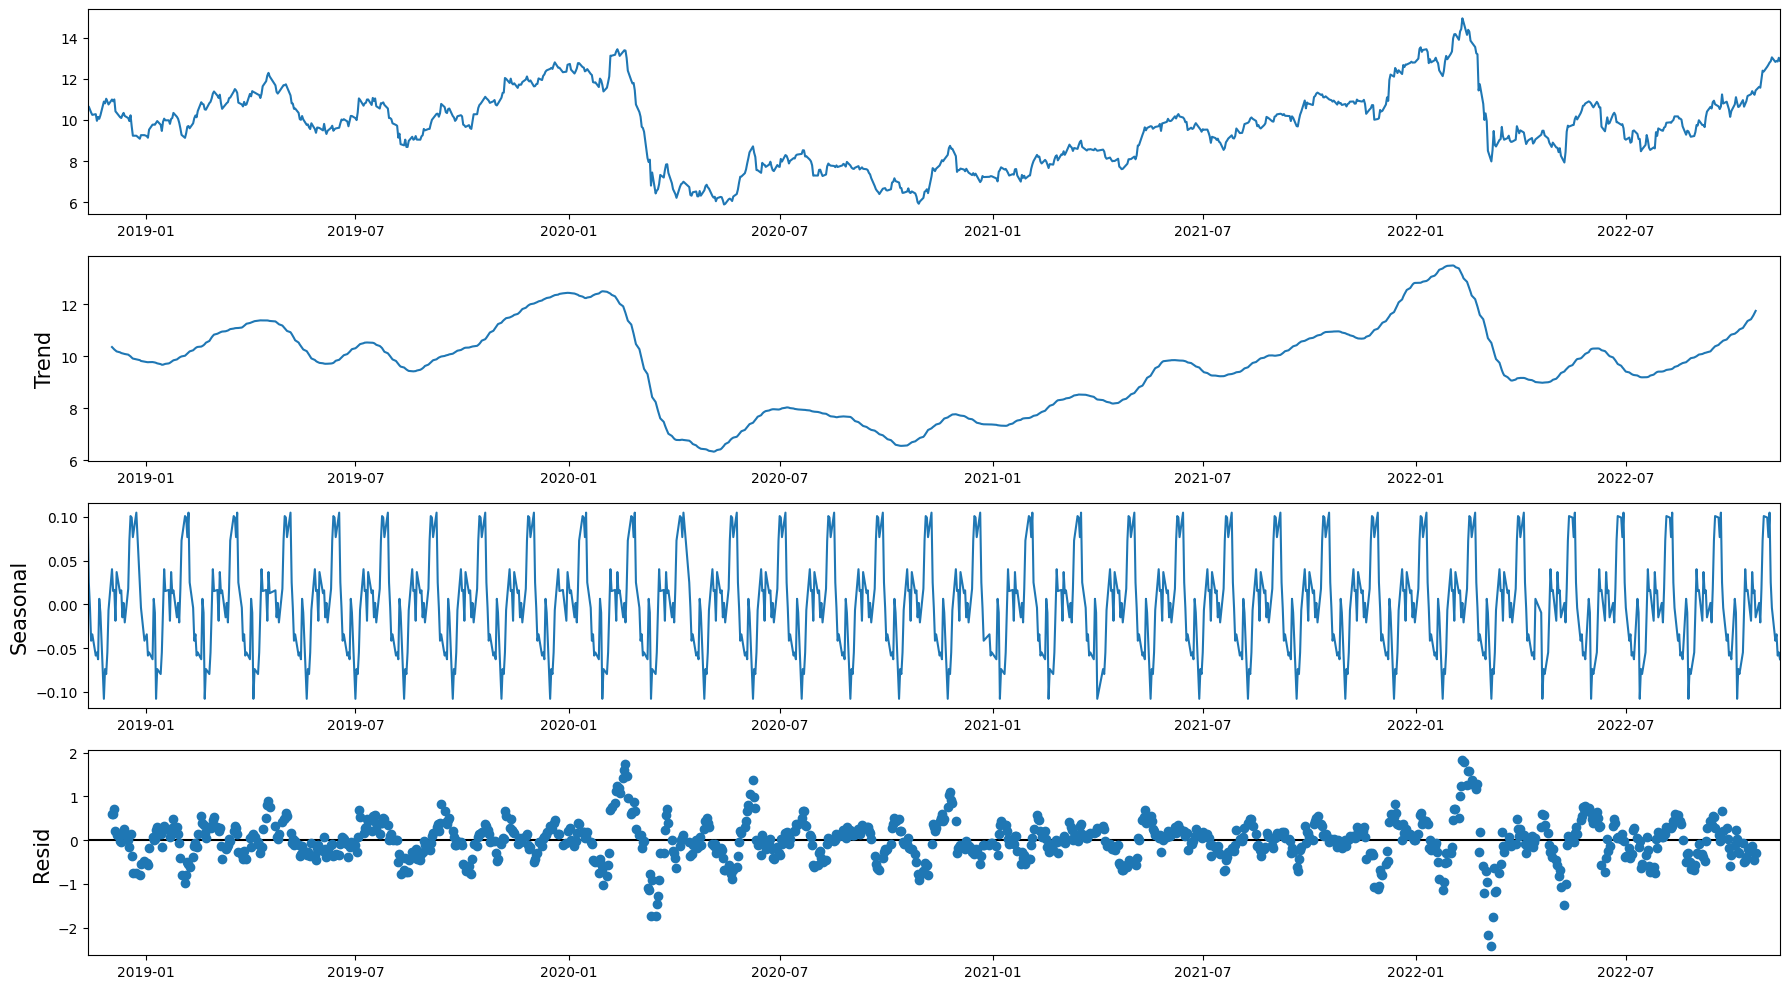

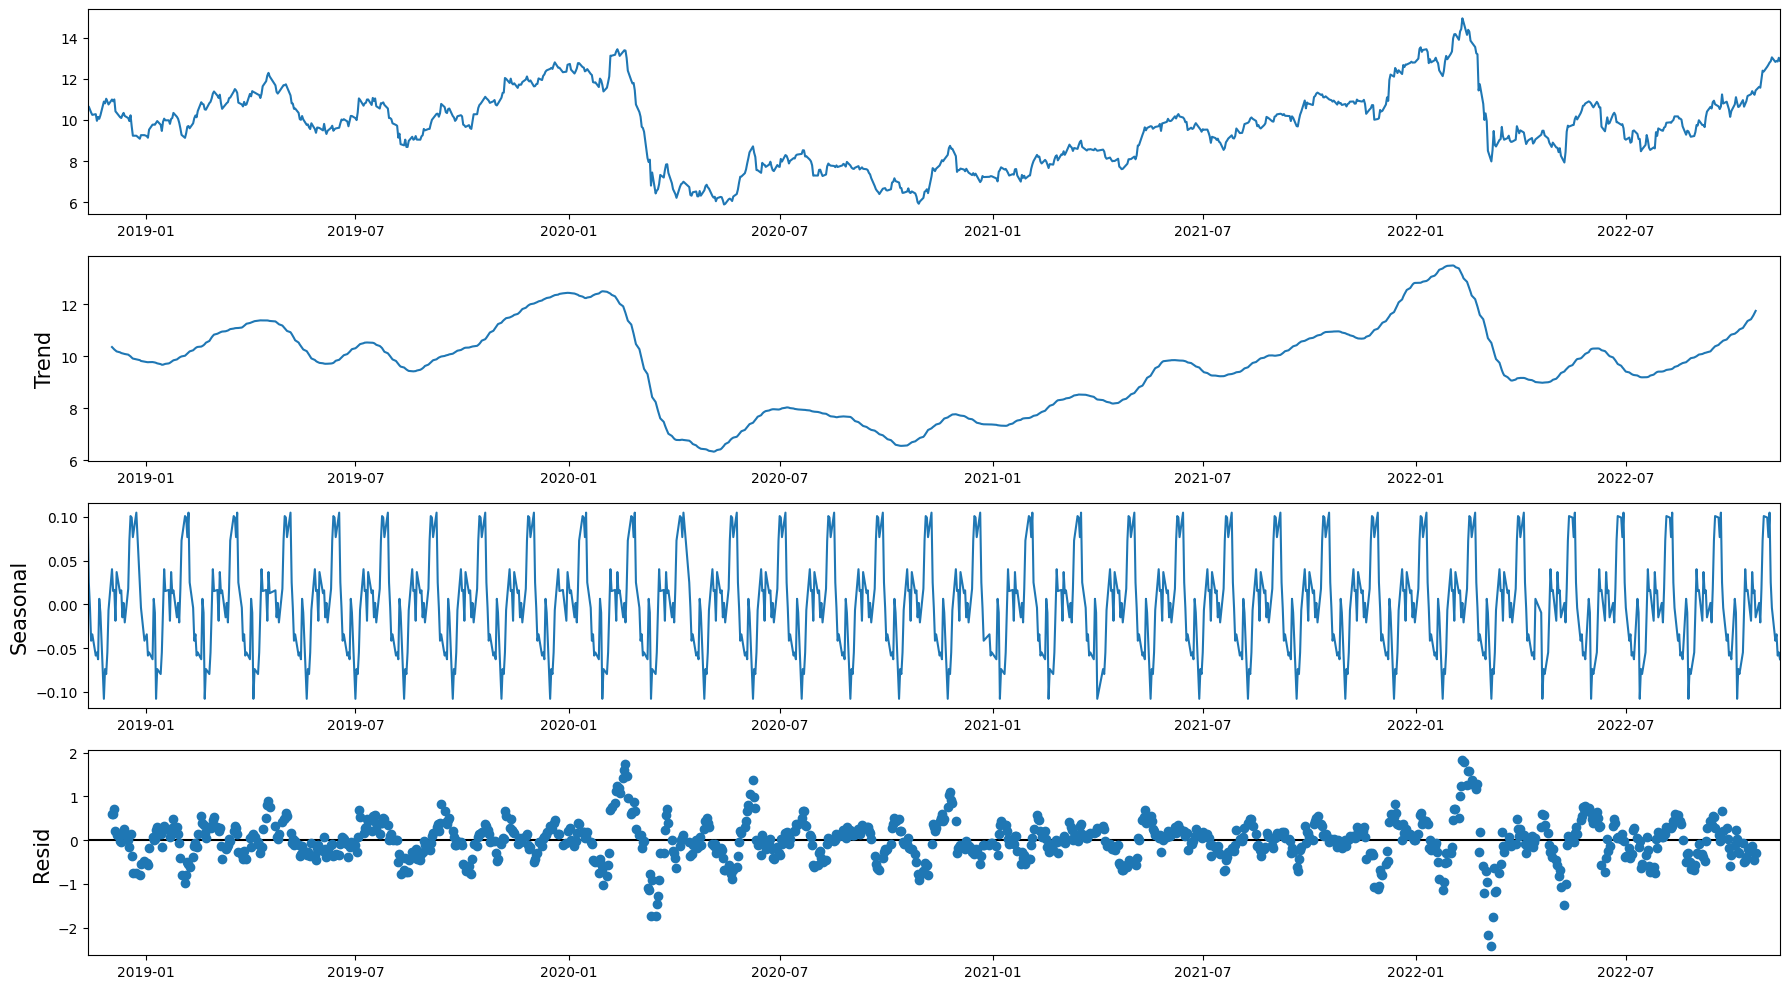

In [5]:
sd = seasonal_decompose(unicredit, period=30)
sd.plot()

In [6]:
def cnn_lstm(ws=30, dtp=1, multi=3):
    
    model = tf.keras.Sequential()

    # Creating the Neural Network model
    # CNN layers
    model.add(TimeDistributed(Conv1D(256, kernel_size=5, padding='same', activation='selu', input_shape=(None, ws, 1))))
    model.add(TimeDistributed(MaxPooling1D(2)))
    model.add(TimeDistributed(Flatten()))
#    model.add(Dense(5, kernel_regularizer=L1(0.01)))

    # LSTM layers
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(multi*ws, return_sequences=False)))
    model.add(Dropout(0.3))

    #Final layers
    model.add(Dense(dtp, activation='linear'))
    model.compile(optimizer='Adamax', loss='mae', metrics=['mse', 'mae', 'mape'])

    return model

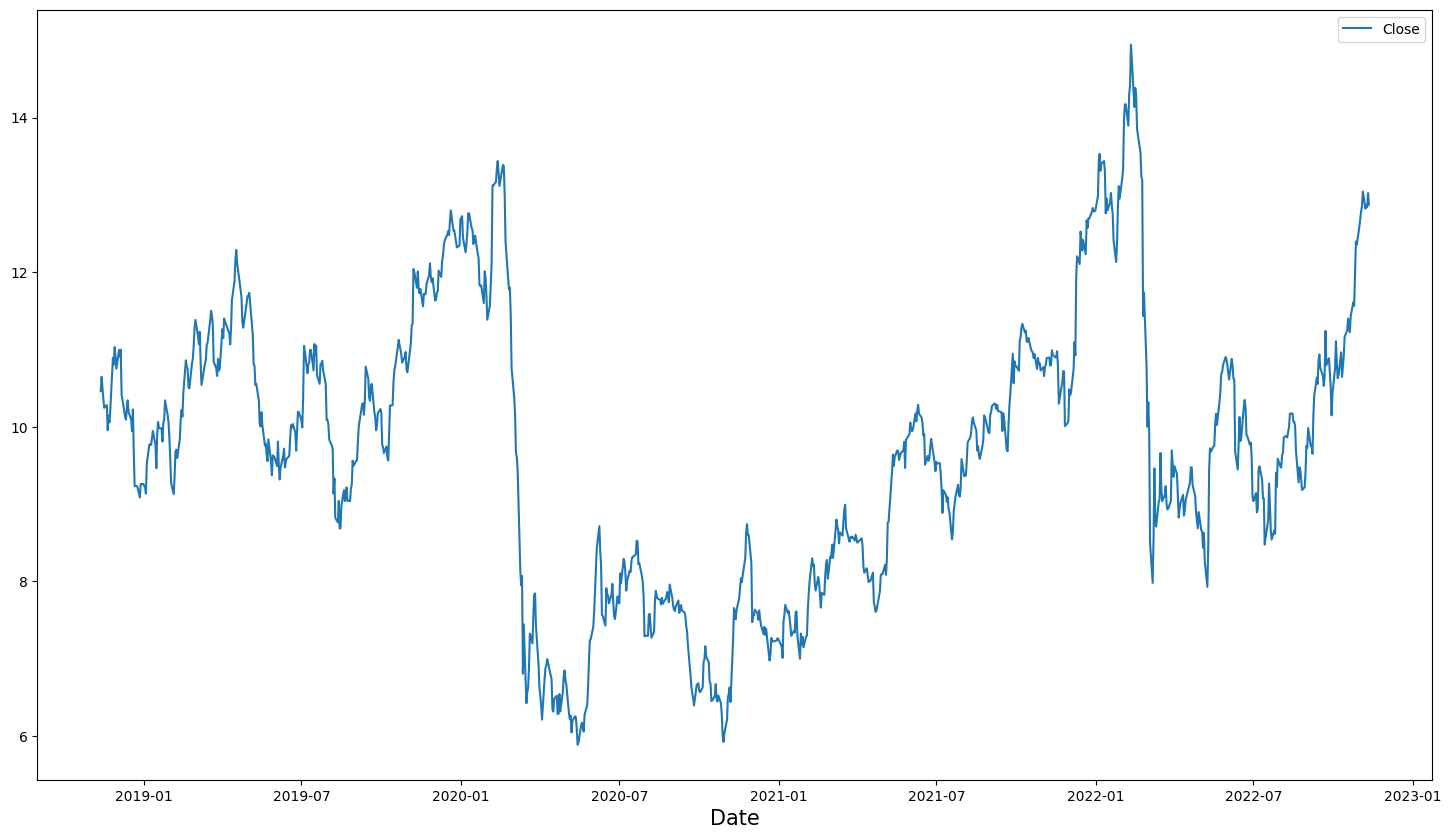

Epoch 1/50
17/17 - 10s - loss: 0.7599 - mse: 0.8699 - mae: 0.7599 - mape: 239.4647 - 10s/epoch - 570ms/step
Epoch 2/50
17/17 - 0s - loss: 0.4820 - mse: 0.4011 - mae: 0.4820 - mape: 852.3726 - 169ms/epoch - 10ms/step
Epoch 3/50
17/17 - 0s - loss: 0.3443 - mse: 0.2155 - mae: 0.3443 - mape: 756.8224 - 197ms/epoch - 12ms/step
Epoch 4/50
17/17 - 0s - loss: 0.2471 - mse: 0.1106 - mae: 0.2471 - mape: 373.8810 - 182ms/epoch - 11ms/step
Epoch 5/50
17/17 - 0s - loss: 0.2005 - mse: 0.0706 - mae: 0.2005 - mape: 368.3337 - 184ms/epoch - 11ms/step
Epoch 6/50
17/17 - 0s - loss: 0.1710 - mse: 0.0539 - mae: 0.1710 - mape: 174.3921 - 179ms/epoch - 11ms/step
Epoch 7/50
17/17 - 0s - loss: 0.1636 - mse: 0.0505 - mae: 0.1636 - mape: 149.8501 - 178ms/epoch - 10ms/step
Epoch 8/50
17/17 - 0s - loss: 0.1566 - mse: 0.0448 - mae: 0.1566 - mape: 93.5980 - 182ms/epoch - 11ms/step
Epoch 9/50
17/17 - 0s - loss: 0.1590 - mse: 0.0449 - mae: 0.1590 - mape: 116.9448 - 194ms/epoch - 11ms/step
Epoch 10/50
17/17 - 0s - loss

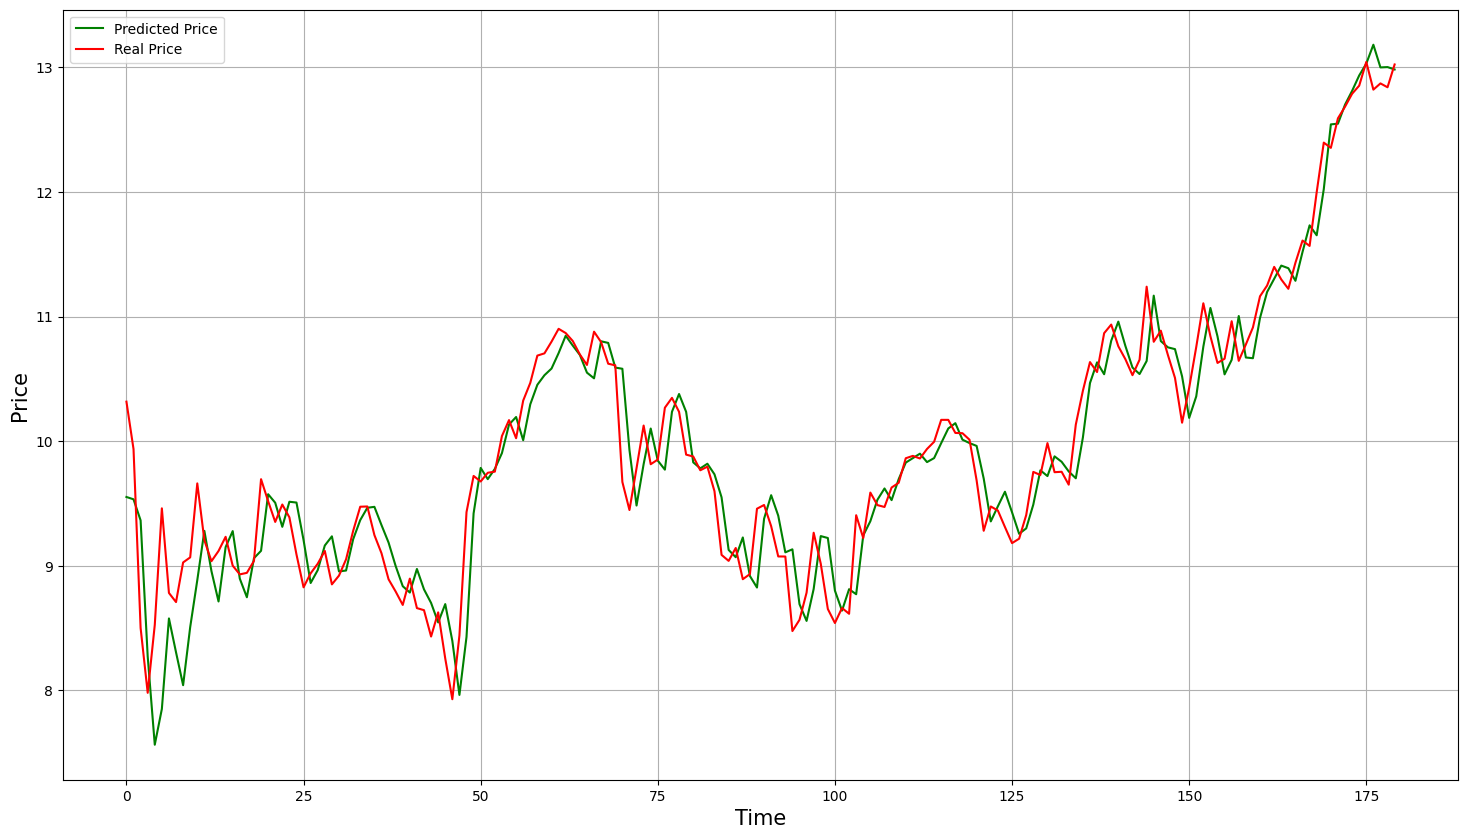

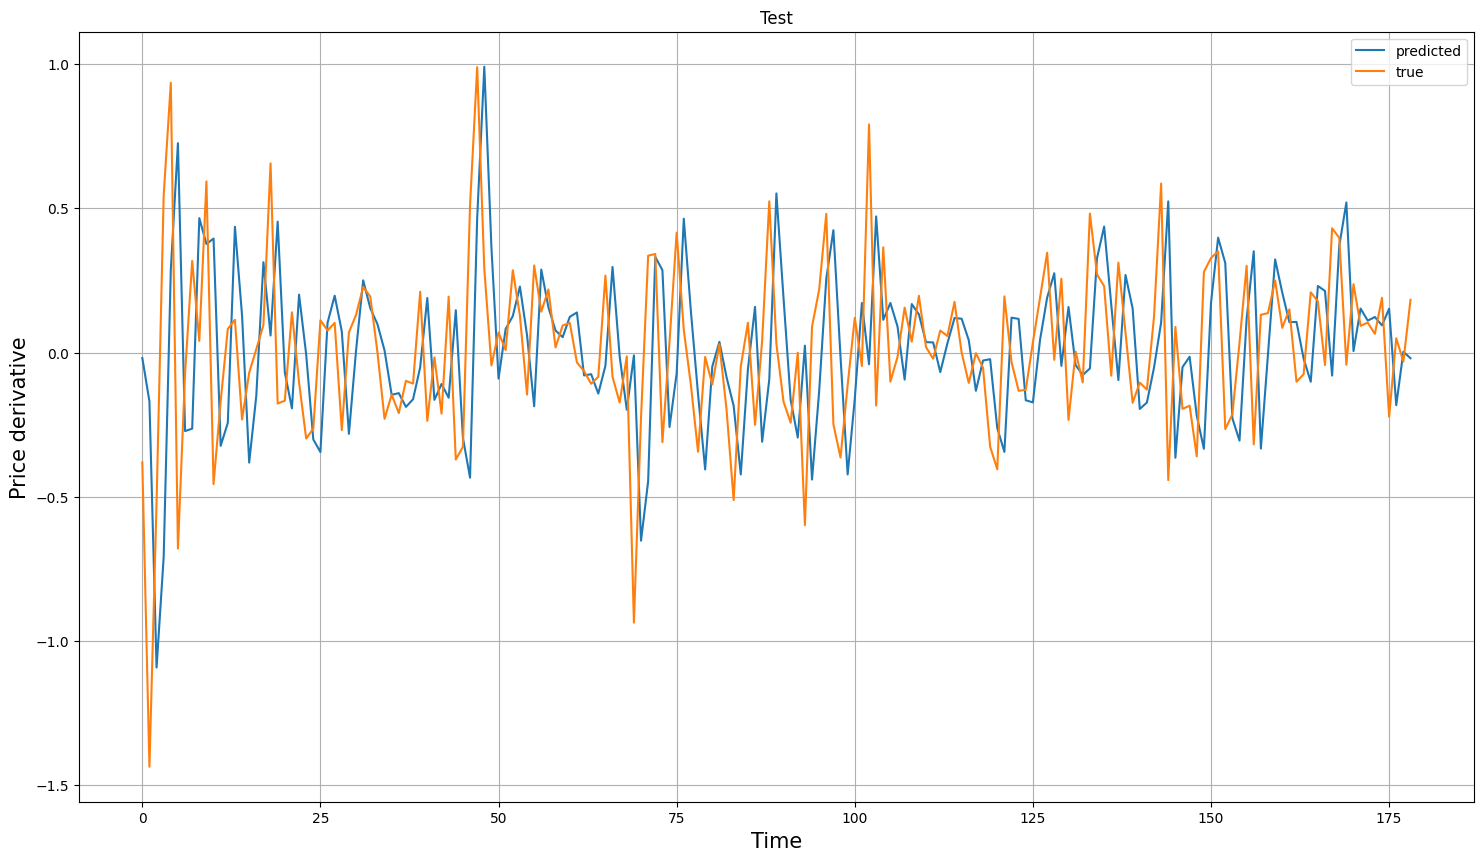

0.5561797752808989


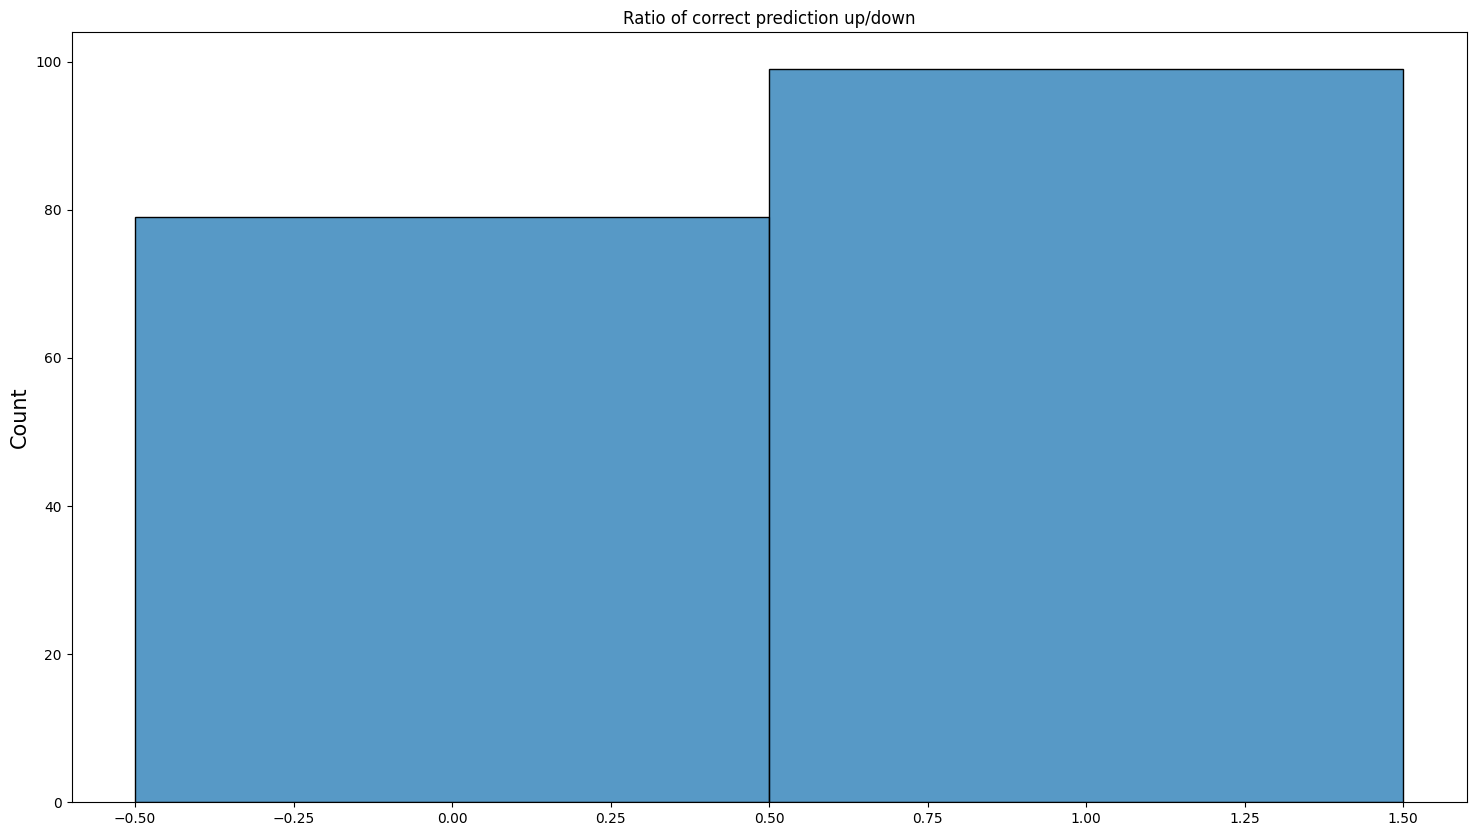

0.33695705134776066 3.106187391049767


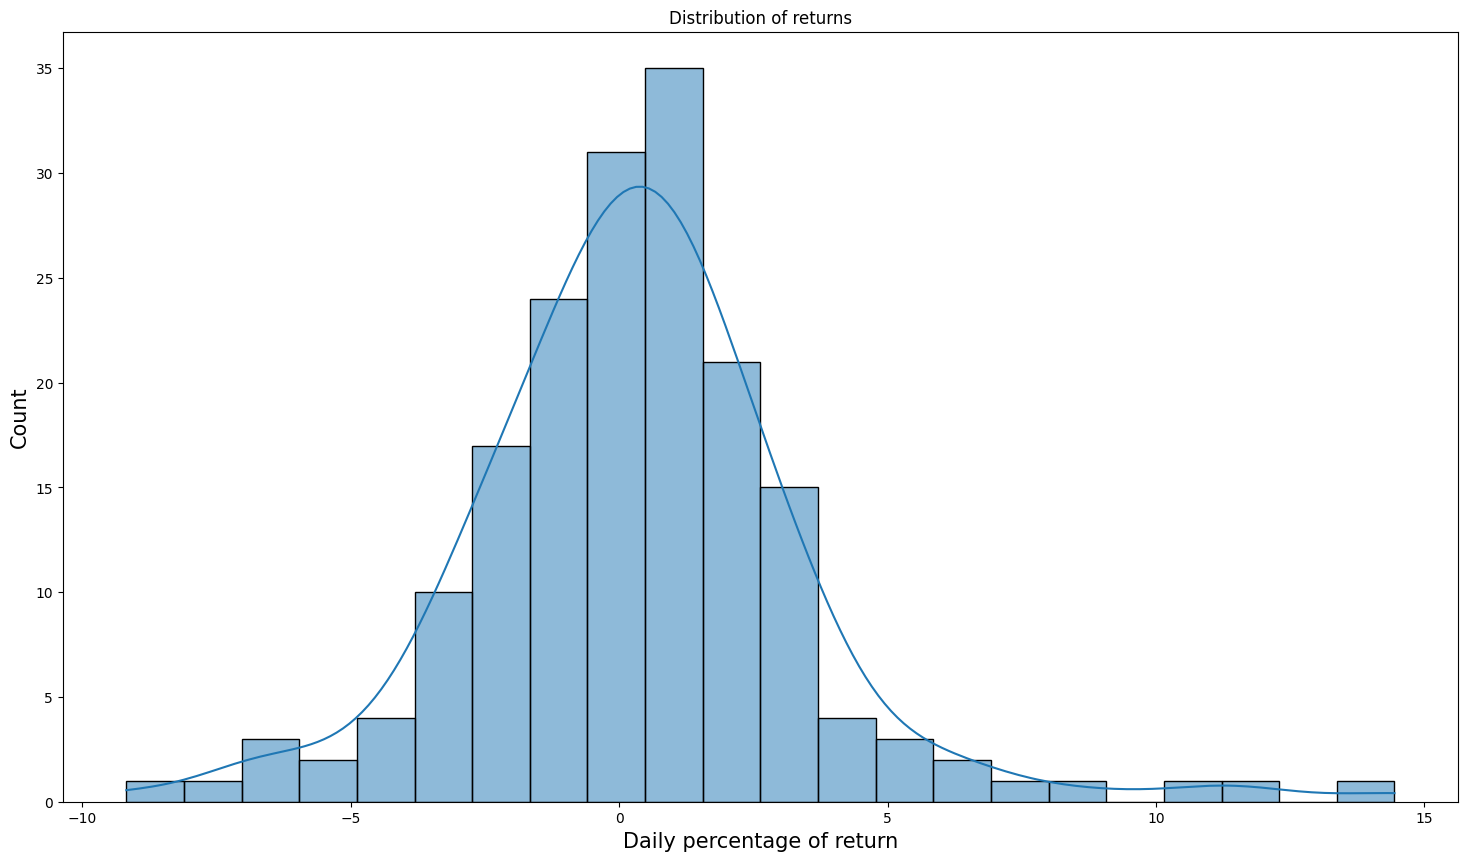

119.95671027980279


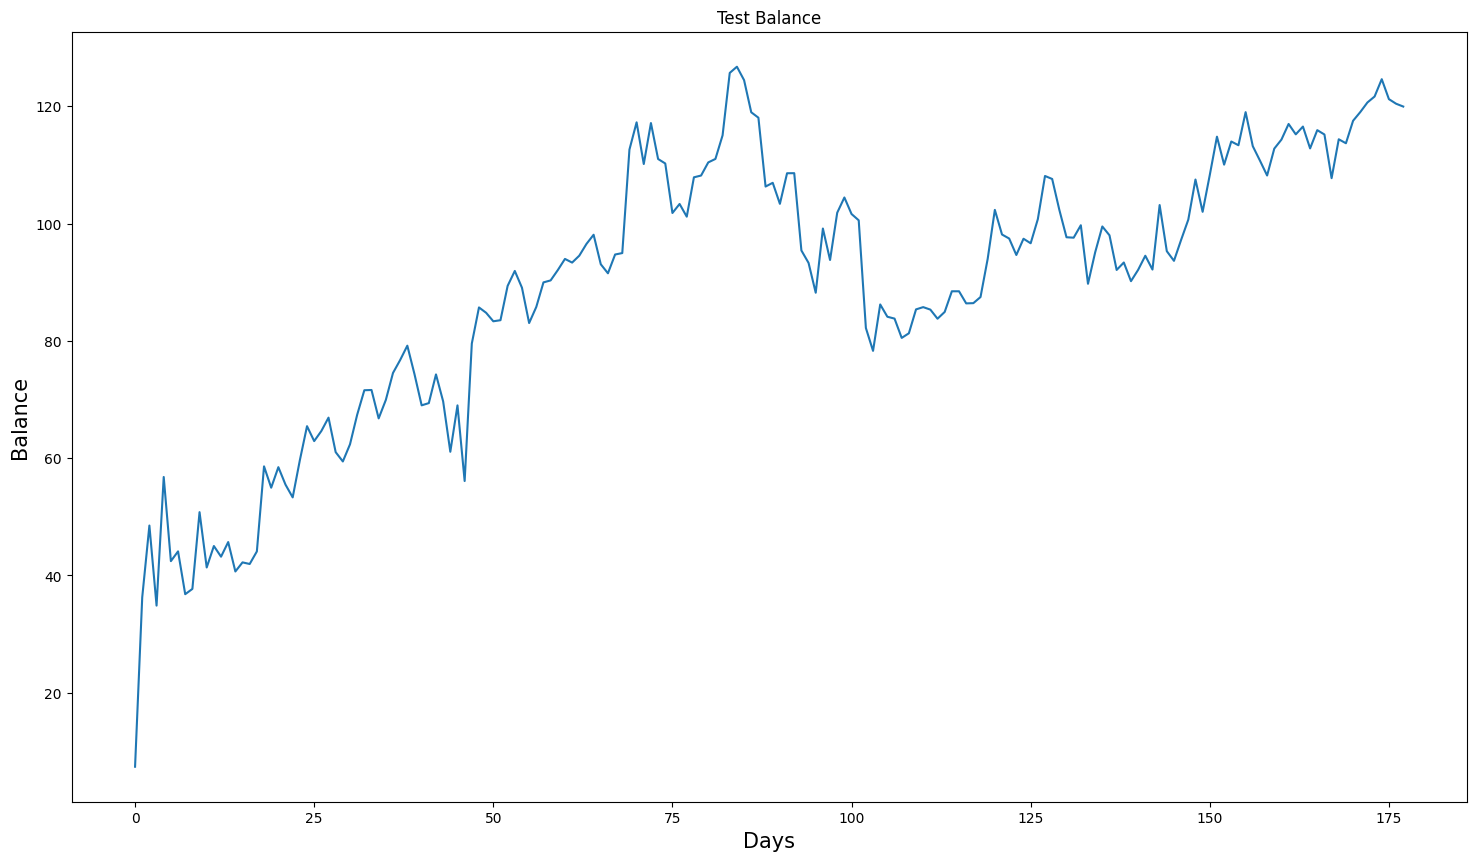

In [7]:
ws = 20
dtp = 1
sns.lineplot(unicredit)
plt.show()

X_train, X_test, y_train, y_test = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=180)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],1,ws,1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],1,ws,1)
    
fs = Forecastsimulator(cnn_lstm(ws=ws, dtp=dtp, multi=3))
fs.train_nn(X_train_reshaped, y_train_scaled, epochs=50, batch_size=50)
prediction = scaler_y.inverse_transform(fs.predict(X_test_reshaped))

fs.plot_prediction(prediction, y_test)
fs.simulate(prediction, y_test)
del fs

In [8]:
'''
dtp=1

X_train, X_test, y_train, y_test = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=30)
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

X_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],1,ws,1)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],1,ws,1)

fs2 = Forecastsimulator(cnn_lstm(ws=ws, dtp=dtp))
pred = fs2.retrain_nn(cnn_lstm(ws=ws, dtp=dtp), X_train_reshaped, X_test_reshaped, y_train_scaled, y_test_scaled, retrain_period=20)
prediction = scaler_y.inverse_transform(pred)

fs2.plot_prediction(prediction, y_test)
fs2.simulate(prediction, y_test)'''

'\ndtp=1\n\nX_train, X_test, y_train, y_test = forecast_split(unicredit, window_size=ws, dtp=dtp, test_days=30)\nscaler_X = StandardScaler()\nscaler_y = StandardScaler()\nX_train_scaled = scaler_X.fit_transform(X_train)\nX_test_scaled = scaler_X.transform(X_test)\ny_train_scaled = scaler_y.fit_transform(y_train)\ny_test_scaled = scaler_y.transform(y_test)\n\nX_train_reshaped = X_train_scaled.reshape(X_train_scaled.shape[0],1,ws,1)\nX_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],1,ws,1)\n\nfs2 = Forecastsimulator(cnn_lstm(ws=ws, dtp=dtp))\npred = fs2.retrain_nn(cnn_lstm(ws=ws, dtp=dtp), X_train_reshaped, X_test_reshaped, y_train_scaled, y_test_scaled, retrain_period=20)\nprediction = scaler_y.inverse_transform(pred)\n\nfs2.plot_prediction(prediction, y_test)\nfs2.simulate(prediction, y_test)'